In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import matplotlib.pyplot as plt

In [4]:
%cd /content/gdrive/MyDrive/IA2022

/content/gdrive/MyDrive/IA2022


In [ ]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D,UpSampling2D
from keras.models import Model, Sequential

def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))
#-----------------------------------------------------------------------------------------
    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generador.add(LeakyReLU(alpha=0.2))

#-----------------------------------------------------------------------------------------
    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generador.add(LeakyReLU(alpha=0.2))

#-----------------------------------------------------------------------------------------

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generador.add(LeakyReLU(alpha=0.2))
    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = 0
modelo_generador = generador_de_imagenes()

modelo_generador.summary()

In [6]:
from keras.models import load_model

modelo_generador = load_model('180_20221130_205919_modelo_generador_.h5')


In [8]:
import numpy as np
#import visualkeras
import random



def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X


def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

Aumento de resolucion

In [9]:
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add


def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


#Generator model
lr_sharpe=(32,32,3)
lr_ip = Input(shape=lr_sharpe)
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [ ]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

In [11]:
from keras.models import load_model

generator = load_model('gen_e_5.h5')


1/1 [==============================] - 0s 16ms/step


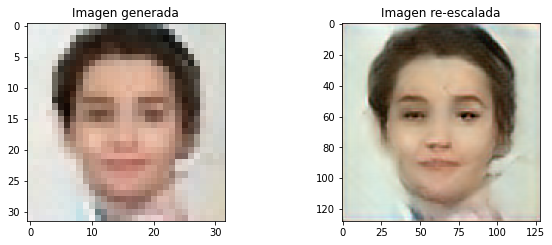

In [28]:
X_fake, _ = crear_datos_fake(n_muestras=1, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2


imagen_escalada=generator.predict_on_batch(X_fake )

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Imagen generada')
plt.imshow(X_fake[0,:,:,:])
plt.subplot(232)
plt.title('Imagen re-escalada')
plt.imshow(imagen_escalada[0,:,:,:])

plt.show()

#plt.imshow(X_fake[0])